## Imports

In [1]:
import PyPDF2
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
from pysentimiento import create_analyzer
import requests
from collections import Counter
from wordcloud import WordCloud
import nltk
import matplotlib.cm as cm
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/home/rafaelnw/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-31 13:57:33.687465: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 13:57:34.809852: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [81]:
#nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rafaelnw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
nltk_stopwords = nltk.corpus.stopwords.words('portuguese')
nltk_stopwords.extend(['0', '1', '2', '3', 
                       '4', '5', '6', '7', 
                       '8', '9', '30', 'ia',
                       'disse', 'por que', 'porque',
                       'deu', 'perguntou', 'vai',
                       'havia'])

## Functions

In [3]:
# Function to extract text from the PDF
def extract_text_from_pdf(pdf_path, start_page, end_page):
    text = ""
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        num_pages = len(reader.pages)
        start_page = max(0, start_page - 1)  # Convert to 0-based index
        end_page = min(num_pages, end_page)  # Ensure the end_page is within the PDF bounds

        for page in range(start_page, end_page):
            page_text = reader.pages[page].extract_text()
            text += page_text
    return text

In [4]:
# Preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Tokenization
    tokens = word_tokenize(text, language='portuguese')  # Adjust the language
    
    # Remove punctuation and special characters
    tokens = [token for token in tokens if re.match(r'^\w+$', token)]
    
    # Remove numbers
    tokens = [token for token in tokens if not token.isdigit()]
    
    # Remove stopwords
    stop_words = set(stopwords.words('portuguese'))  # Adjust the language
    tokens = [token for token in tokens if token not in stop_words]
    
    # Join tokens back into text
    preprocessed_text = " ".join(tokens)
    
    return preprocessed_text

In [5]:
# Tokenize the text and count word frequencies
def get_top_words(text, n=10, stopwords=None):
    words = re.findall(r'\w+', text.lower())
    if stopwords:
        words = [word for word in words if word not in stopwords]
    word_counts = Counter(words)
    return word_counts.most_common(n)

In [6]:
# Define a function to convert the month name to a numerical value
def get_month_number(month_name):
    months = {
        'JANEIRO': 1, 'FEVEREIRO': 2, 'MARÇO': 3, 
        'ABRIL': 4, 'MAIO': 5, 'JUNHO': 6,
        'JULHO': 7, 'AGOSTO': 8, 'SETEMBRO': 9, 
        'OUTUBRO': 10, 'NOVEMBRO': 11, 'DEZEMBRO': 12
    }
    return months.get(month_name.upper(), -1)

## Data manipulation

In [ ]:
# URL to the PDF file
pdf_url = "https://dpid.cidadaopg.sp.gov.br/pde/arquivos/1623677495235~Quarto%20de%20Despejo%20-%20Maria%20Carolina%20de%20Jesus.pdf.pdf"

# Download the PDF file from the URL
response = requests.get(pdf_url)
with open("quarto_despejo.pdf", "wb") as pdf_file:
    pdf_file.write(response.content)

In [7]:
# Path to the PDF file
pdf_path = "quarto_despejo.pdf"

# Extract text from pages 10 to 166 of the PDF
book_text = extract_text_from_pdf(pdf_path, start_page=10, end_page=166)

In [8]:
# Split the text into individual diary
entries = re.split(r'\d+\s+DE\s+[A-Z]+\s+DE\s+\d+|\d+\s+DE\s+[A-Z]+\s*', book_text)
entries = [entry.strip() for entry in entries if entry.strip()]

In [9]:
# Create a list of tuples with date and entry
date_entry_tuples = []
date_pattern = r'(\d+)\s+DE\s+([A-Z]+)\s+(?:DE\s+)?(\d+)'
alternative_date_pattern = r'(\d+)\s+DE\s+([A-Z]+)'

for date_match, entry in zip(re.finditer(date_pattern, book_text), entries):
    day, month, year = date_match.groups()
    date = f"{day} DE {month} DE {year}"
    date_entry_tuples.append((date, entry))

for date_match, entry in zip(re.finditer(alternative_date_pattern, book_text), entries):
    day, month = date_match.groups()
    date = f"{day} DE {month}"
    date_entry_tuples.append((date, entry))

# Create a DataFrame from the list of tuples
df = pd.DataFrame(date_entry_tuples, columns=['Date', 'Entry'])

In [10]:
# Split the text into individual diary entries using regex
entries = re.split(r'\d+\s+DE\s+[A-Z]+\s*(?:DE\s+\d+)?', book_text)
entries = [entry.strip() for entry in entries if entry.strip()]

# Extract dates and entries
date_entry_tuples = []
date_pattern = r'(\d+)\s+DE\s+([A-Z]+)\s+(?:DE\s+(\d+))?'
for date_match, entry in zip(re.finditer(date_pattern, book_text), entries):
    day, month, year = date_match.groups()
    date = f"{day} DE {month}"
    if year:
        date = f"{date} DE {year}"
    date_entry_tuples.append((date, entry))

# Create a DataFrame
df = pd.DataFrame(date_entry_tuples, columns=['Date', 'Entry'])

## Sentiment Analysis

In [11]:
analyzer = create_analyzer(task="sentiment", lang="pt")

In [12]:
# Loop through entries and perform sentiment analysis
for index, row in df.iterrows():
    entry = row['Entry']
    sentiment_output = analyzer.predict(entry)  # Replace 'analyzer' with your sentiment analysis model
    
    # Access sentiment label and probabilities
    sentiment_label = sentiment_output.output
    proba_neu = sentiment_output.probas['NEU']
    proba_neg = sentiment_output.probas['NEG']
    proba_pos = sentiment_output.probas['POS']
    
    # Save sentiment label and probabilities to DataFrame
    df.at[index, 'Sentiment'] = sentiment_label
    df.at[index, 'Proba_NEU'] = proba_neu
    df.at[index, 'Proba_NEG'] = proba_neg
    df.at[index, 'Proba_POS'] = proba_pos

In [13]:
# Extract day, month, and year information from the "Date" column
df['Day'] = df['Date'].str.extract(r'(\d+) DE')
df['Month'] = df['Date'].str.extract(r'DE (\w+) DE')
df['Year'] = df['Date'].str.extract(r'DE (\d{4})')

# Handle missing or NaN values in the "Month" column
df['Month'] = df['Month'].fillna(method='ffill')

# Apply the function to convert month names to numerical values
df['Month'] = df['Month'].apply(get_month_number)

# Handle missing or NaN values in the "Year" column
df['Year'] = df['Year'].fillna(method='ffill')

# Create a datetime column
df['Formatted_Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce')

In [14]:
# Create VADER sentiment analyzer instance
analyzer_vader = SentimentIntensityAnalyzer()

# Create empty lists to store sentiment scores
compound_scores = []
positive_scores = []
negative_scores = []
neutral_scores = []

# Loop through entries and analyze sentiment
for entry in df['Entry']:
    sentiment_scores = analyzer_vader.polarity_scores(entry)
    
    compound_scores.append(sentiment_scores['compound'])
    positive_scores.append(sentiment_scores['pos'])
    negative_scores.append(sentiment_scores['neg'])
    neutral_scores.append(sentiment_scores['neu'])

# Add sentiment scores as columns to DataFrame
df['Vader_Compound'] = compound_scores
df['Vader_Positive'] = positive_scores
df['Vader_Negative'] = negative_scores
df['Vader_Neutral'] = neutral_scores

In [15]:
# Function to classify Vader Compound score
def classify_vader(compound_score):
    if compound_score > 0.05:
        return "POS"
    elif compound_score < -0.05:
        return "NEG"
    else:
        return "NEU"

# Apply the classification function to create the Vader_Classified column
df['Vader_Classified'] = df['Vader_Compound'].apply(classify_vader)

## Visualization

In [16]:
# Create a mapping between abbreviations and full sentiment names
sentiment_mapping = {
    'NEU': 'neutral',
    'POS': 'positive',
    'NEG': 'negative'
}

vader_mapping = sentiment_mapping

/tmp/ipykernel_30503/83371872.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('inferno')


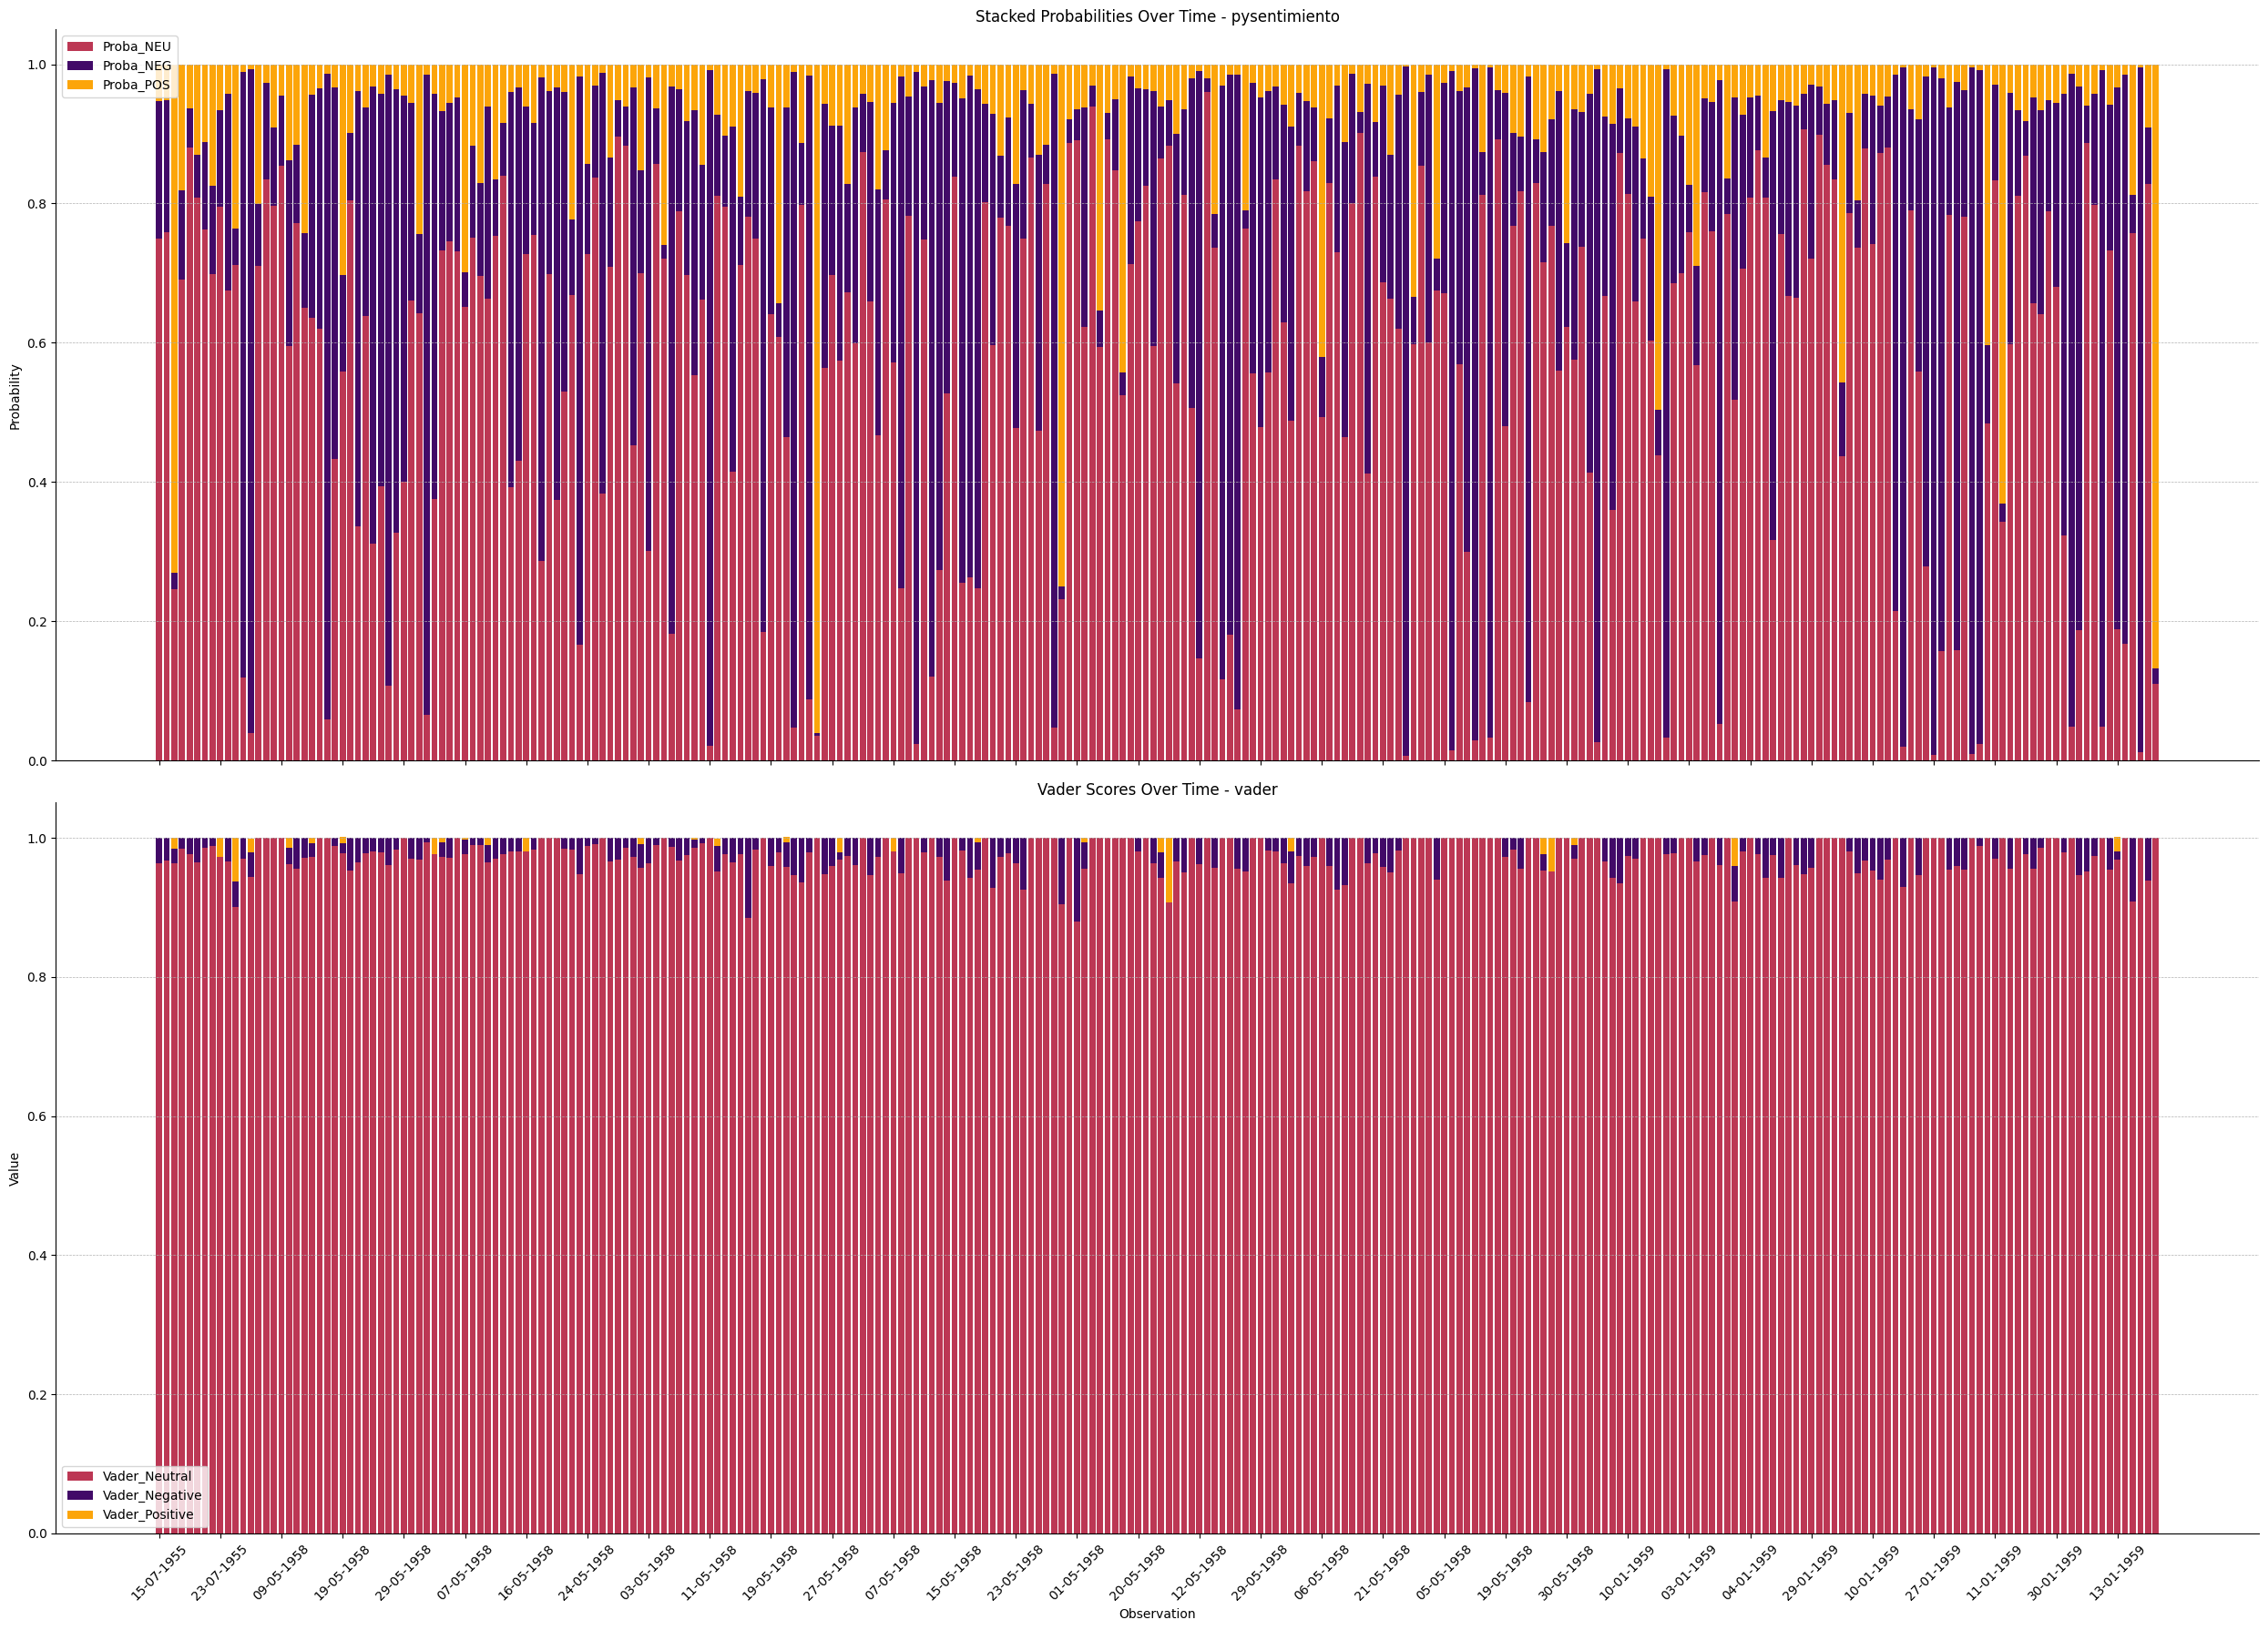

In [17]:
# Create a list of tick positions and labels (show every 2nd date)
tick_positions = range(0, len(df), 8)  # Show every 2nd date
tick_labels = df['Formatted_Date'][tick_positions].dt.strftime('%d-%m-%Y')  # Use formatted dates as tick labels

# Set the color map
color_map = cm.get_cmap('inferno')

# Create a figure with two rows and one column of subplots
fig, axes = plt.subplots(2, 1, figsize=(25, 18), sharex=True)

# Define the width of the bars
bar_width = 0.8

# Plot the stacked bars for probabilities on the first subplot
axes[0].bar(df.index, df['Proba_NEU'], color=color_map(0.5), width=bar_width, label='Proba_NEU')
axes[0].bar(df.index, df['Proba_NEG'], bottom=df['Proba_NEU'], color=color_map(0.2), width=bar_width, label='Proba_NEG')
axes[0].bar(df.index, df['Proba_POS'], bottom=df['Proba_NEU'] + df['Proba_NEG'], width=bar_width, color=color_map(0.8), label='Proba_POS')

axes[0].set_title('Stacked Probabilities Over Time - pysentimiento')
axes[0].set_ylabel('Probability')
axes[0].legend()

# Remove vertical grid lines and box around the first subplot
axes[0].grid(axis='y', which='both', linestyle='--', linewidth=0.5)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Smooth horizontal grid lines in the first subplot
axes[0].yaxis.grid(True, linestyle='--', linewidth=0.5)

# Plot the bars for Vader scores on the second subplot
axes[1].bar(df.index, df['Vader_Neutral'], color=color_map(0.5), width=bar_width, label='Vader_Neutral')
axes[1].bar(df.index, df['Vader_Negative'], bottom=df['Vader_Neutral'], color=color_map(0.2), width=bar_width, label='Vader_Negative')
axes[1].bar(df.index, df['Vader_Positive'], bottom=df['Vader_Neutral'] + df['Vader_Negative'], width=bar_width, color=color_map(0.8), label='Vader_Positive')

axes[1].set_title('Vader Scores Over Time - vader')
axes[1].set_xlabel('Observation')
axes[1].set_ylabel('Value')
axes[1].legend()

# Remove vertical grid lines and box around the second subplot
axes[1].grid(axis='y', which='both', linestyle='--', linewidth=0.5)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Smooth horizontal grid lines in the second subplot
axes[1].yaxis.grid(True, linestyle='--', linewidth=0.5)

# Set custom tick positions and labels for the x-axis
axes[1].set_xticks(tick_positions)
axes[1].set_xticklabels(tick_labels, rotation=45)

plt.tight_layout()

plt.show()

Compared with the analysis of the Pysentimiento library, the sentiment values ​​from the Vader library have less variability, with a large number of observations with neutral sentiments.

There is no prevailing sentiment, apparent over time, for both analyses.

In [82]:
# Filter rows with Proba_POS >= 0.6
filtered_df = df[df['Proba_POS'] >= 0.6]

# Iterate through the rows and print the 'Entry' column
for index, row in filtered_df.iterrows():
    print(row['Entry'])

Domingo.	Um	dia	maravilhoso.	O	céu	azul	sem	nuvem.
O	Sol	está	tépido.	Deixei	o	leito	as	6,30.	Fui	buscar	agua.	Fiz	café.	Tendo	só	um
pedaço	de	pão	e	3	cruzeiros.	Dei	um	pedaço	a	cada	um,	puis	feijão	no	fogo	que
ganhei	ontem	do	Centro	Espirita	da	Rua	Vergueiro	103.	Fui	lavar	minhas	roupas.
Quando	retornei	do	rio	o	feijão	estava	cosido.	Os	filhos	pediram	pão.	Dei	os	3
cruzeiros	ao	João	José	para	ir	comprar	pão.	Hoje	é	a	Nair	Mathias	quem
começou	impricar	com	os	meus	filhos.	A	Silvia	e	o	esposo	já	iniciaram	o
espetáculo	ao	ar	livre.	Ele	está	lhe	espancando.	E	eu	estou	revoltada	com	o	que
as	crianças	presenciam.	Ouvem	palavras	de	baixo	calão.	Oh!	se	eu	pudesse
mudar	daqui	para	um	núcleo	mais	decente.
Fui	na	D.	Floreia	pedir	um	dente	de	alho.	E	fui	na	D.	Analia.	E	recebi	o
que	esperava:—Não	tenho!
Fui	torcer	as	minhas	roupas.	A	D.	Aparecida	perguntou-me:
—A	senhora	está	gravida?
—Não	senhora	—	respondi	gentilmente.
E	lhe	chinguei	interiormente.	Se	estou	gravida	não	é	de	sua	conta.	Tenho
pav

Analyzing each diary entry with a positive sentiment probability greater than or equal to 0.6, it's evident that on July 17, 1955, the text begins "Domingo. Um dia maravilhoso. O céu azul sem nuvem. O Sol está tépido. Deixei o leito as 6,30. Fui buscar agua." This beginning might have influenced the result of a higher probability of positive sentiment. However, the entire text following this passage does not appear to convey positive sentiments.
For the diary entry on August 30, 1958 (".Passei no Frigorífico, ganhei ossos. Cheguei no deposito, ganhei 10 cruzeiros. Depois circulei pela rua Porto Seguro. Encontrei com aquele moço loiro, alto e bonito."), the positive sentiment result seems consistent with the entirety of this entry.
For the other dates, July 25, 1958, July 12, 1959, and January 1, 1960, the passages are short and seem to contain positive sentiments.

In [61]:
# Filter rows with Proba_POS >= 0.6
filtered_df_vader = df[df['Vader_Positive'] >= 0.6]

# Iterate through the rows and print the 'Entry' column
for index, row in filtered_df_vader.iterrows():
    print(row['Entry'])

There are none of Vader_Positive values above or equal to 0.6

/tmp/ipykernel_31656/1824034274.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('inferno')


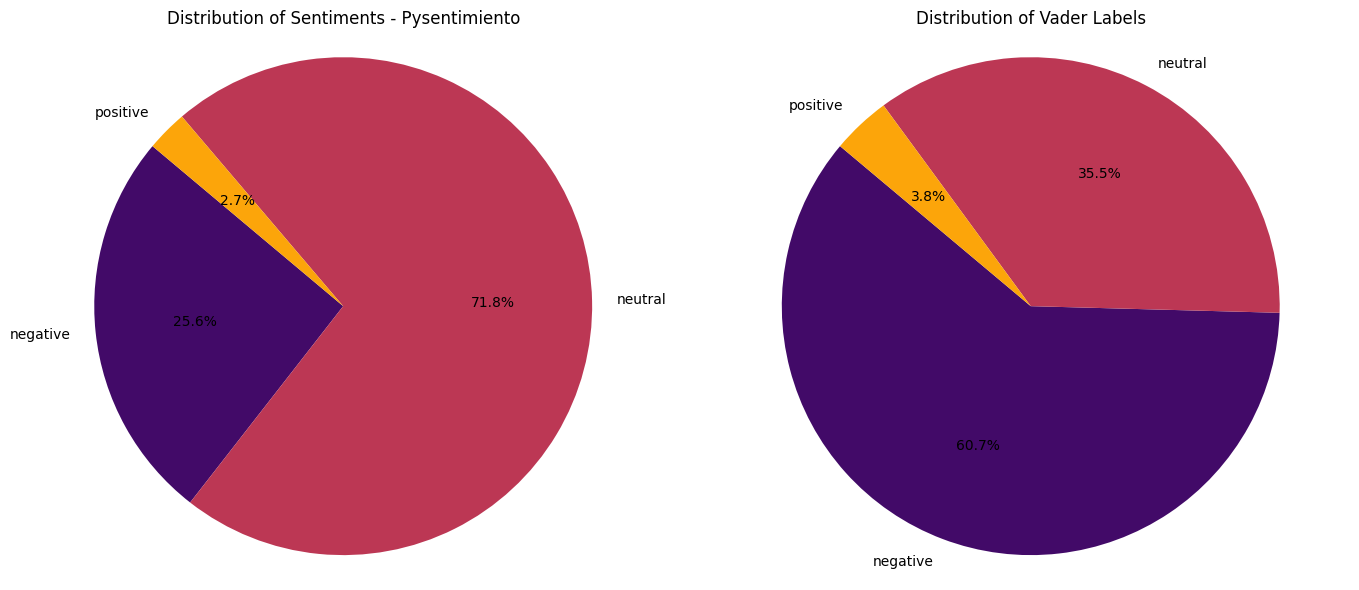

In [67]:
# Group the DataFrame by 'Sentiment' and count the number of rows in each group
sentiment_counts = df.groupby('Sentiment').size()

# Create a figure with one row and two columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Set the color map
color_map = cm.get_cmap('inferno')

# Plot the pie chart for original sentiments in the first subplot
axes[0].pie(sentiment_counts, labels=sentiment_counts.index.map(sentiment_mapping), autopct='%1.1f%%', startangle=140, colors=color_map([0.2, 0.5, 0.8]))
axes[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axes[0].set_title('Distribution of Sentiments - Pysentimiento')

# Group the DataFrame by 'Vader_Label' and count the number of rows in each group
vader_counts = df.groupby('Vader_Classified').size()

# Plot the pie chart for Vader labels in the second subplot
axes[1].pie(vader_counts, labels=vader_counts.index.map(vader_mapping), autopct='%1.1f%%', startangle=140, colors=color_map([0.2, 0.5, 0.8]))
axes[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axes[1].set_title('Distribution of Vader Labels')

plt.tight_layout()
plt.show()

Carolina's text describes the struggle for survival in a slum, the challenges faced in raising her children, poverty, and hunger. According to the distribution of sentiments, there is a higher predominance of neutral sentiments, which seems to contrast with the story described in the book. A greater predominance of negative sentiments is expected. This predominance can be observed in the analyzes using the Vader library. The difference observed between the proportions of positive, negative and neutral sentiments, differs from the raw probabilities for each of the sentiments, observed in the previous bar graph.

One should evaluate how the final sentiment classification is done for Pysentimiento library. The scale on which the values ​​are calculated may also have influenced this result.

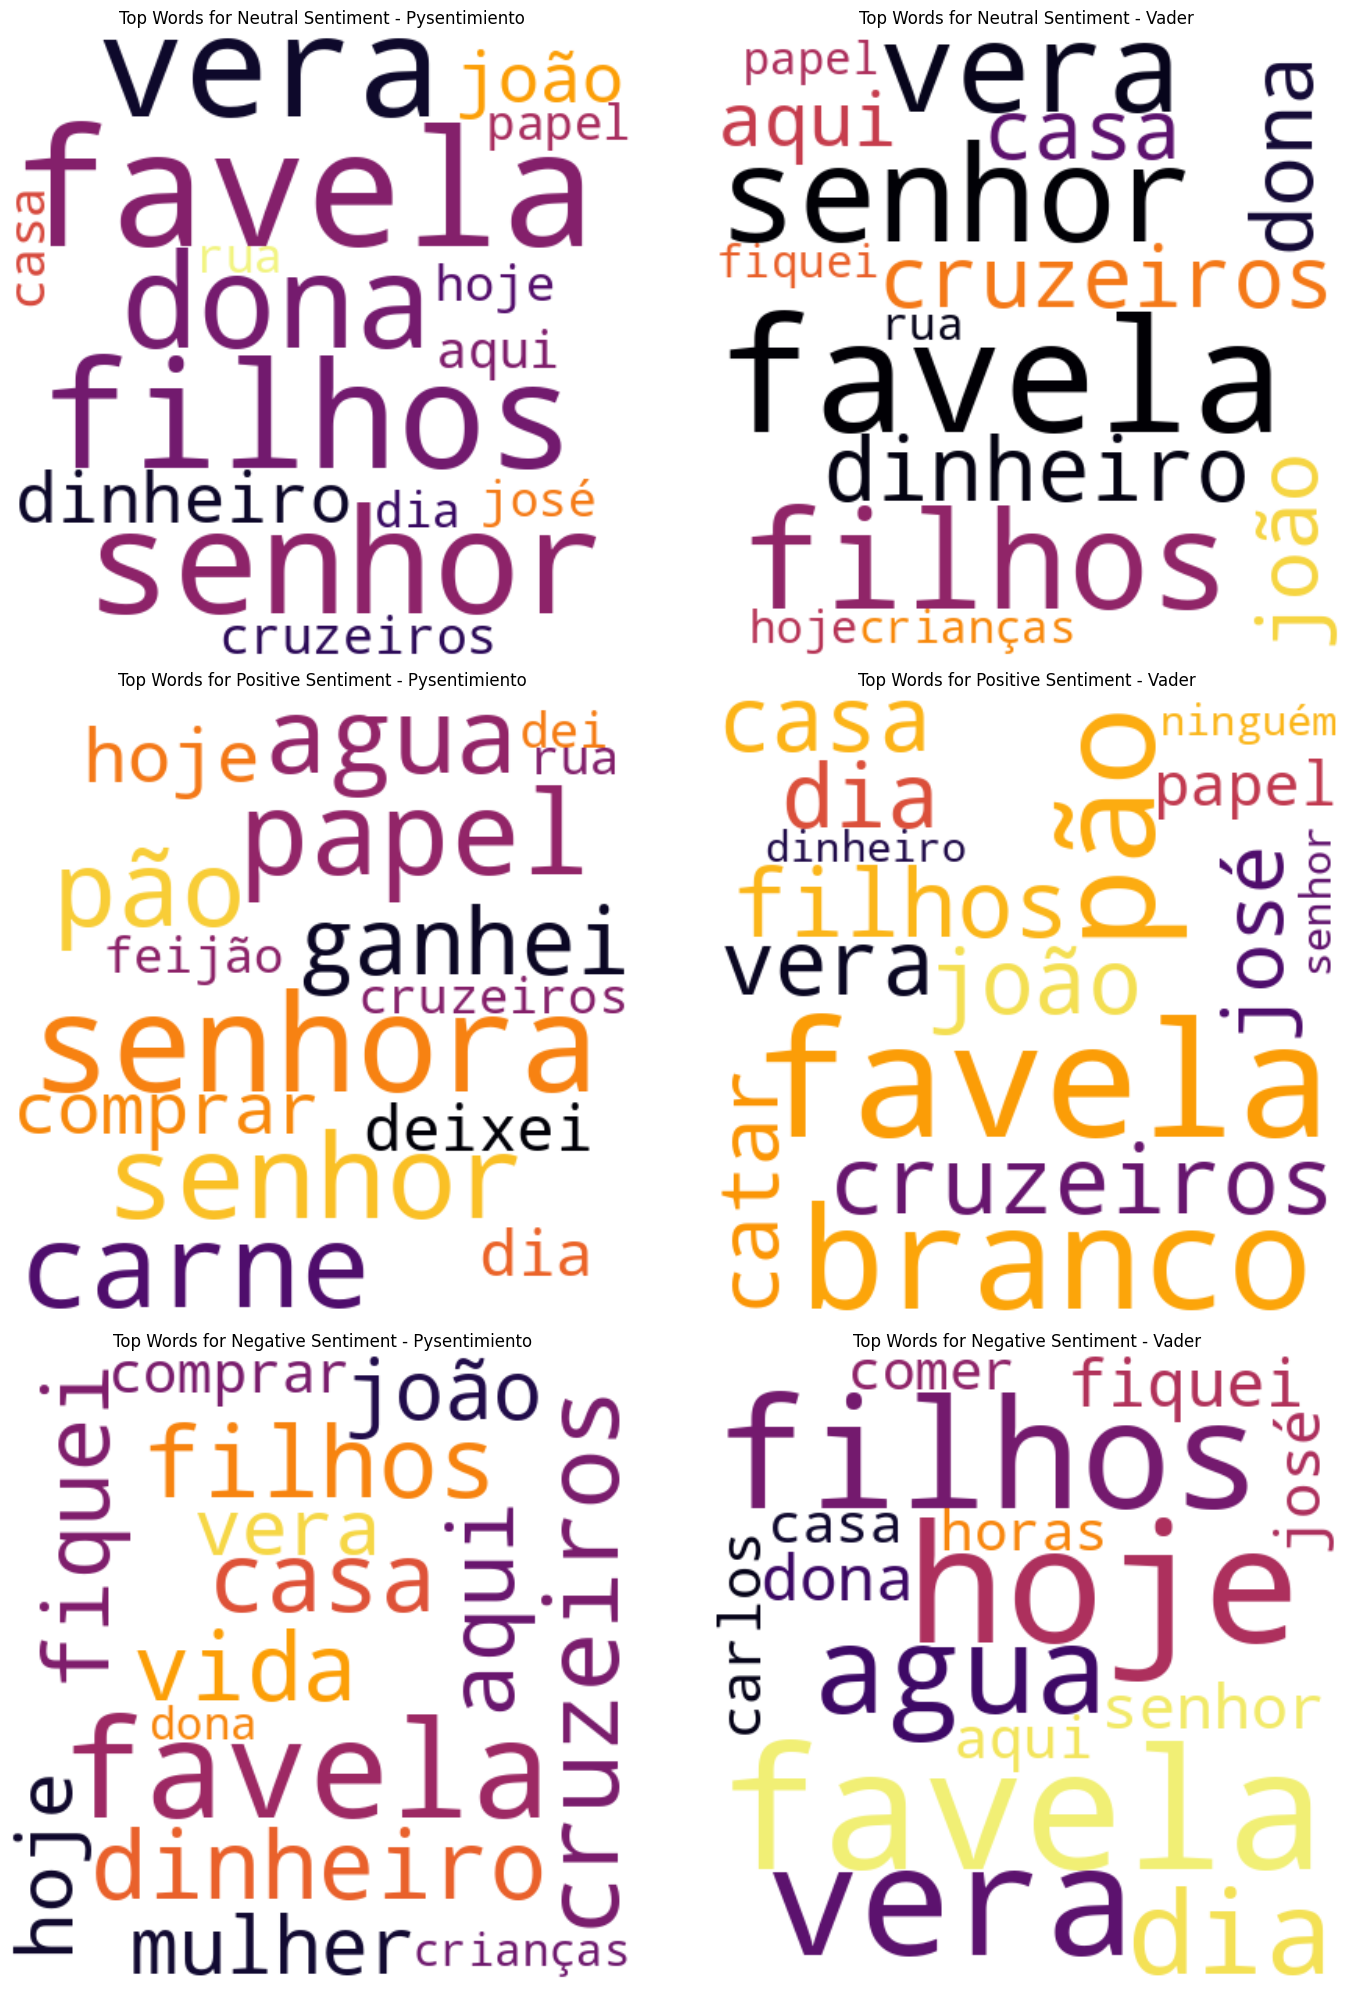

In [29]:
# Tokenize the text and count word frequencies
def get_top_words(text, n=10, stopwords=None):
    words = re.findall(r'\w+', text.lower())
    if stopwords:
        words = [word for word in words if word not in stopwords]
    word_counts = Counter(words)
    return word_counts.most_common(n)

sentiment_mapping = {'NEU': 'Neutral', 'POS': 'Positive', 'NEG': 'Negative'}
vader_labels = df['Vader_Classified'].unique()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 20))
colormap = plt.get_cmap('inferno')

for idx, sentiment in enumerate(df['Sentiment'].unique()):
    ax = axes[idx, 0]
    
    filtered_df = df[df['Sentiment'] == sentiment]
    combined_text = ' '.join(filtered_df['Entry'])
    
    top_words = get_top_words(combined_text, n=15, stopwords=nltk_stopwords)
    
    wordcloud = WordCloud(width=400, height=400, background_color='white', colormap=colormap)
    wordcloud.generate_from_frequencies(dict(top_words))
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Top Words for {sentiment_mapping[sentiment]} Sentiment - Pysentimiento')
    ax.axis('off')

for idx, sentiment in enumerate(df['Sentiment'].unique()):
    ax = axes[idx, 1]
    
    label = vader_labels[idx]
    filtered_df = df[df['Vader_Classified'] == label]
    combined_text = ' '.join(filtered_df['Entry'])
    
    top_words = get_top_words(combined_text, n=15, stopwords=nltk_stopwords)
    
    wordcloud = WordCloud(width=400, height=400, background_color='white', colormap=colormap)
    wordcloud.generate_from_frequencies(dict(top_words))
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Top Words for {sentiment_mapping[sentiment]} Sentiment - Vader')
    ax.axis('off')

plt.tight_layout()
plt.show()

/tmp/ipykernel_30503/1390632273.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(words, rotation=45)
/tmp/ipykernel_30503/1390632273.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(words, rotation=45)


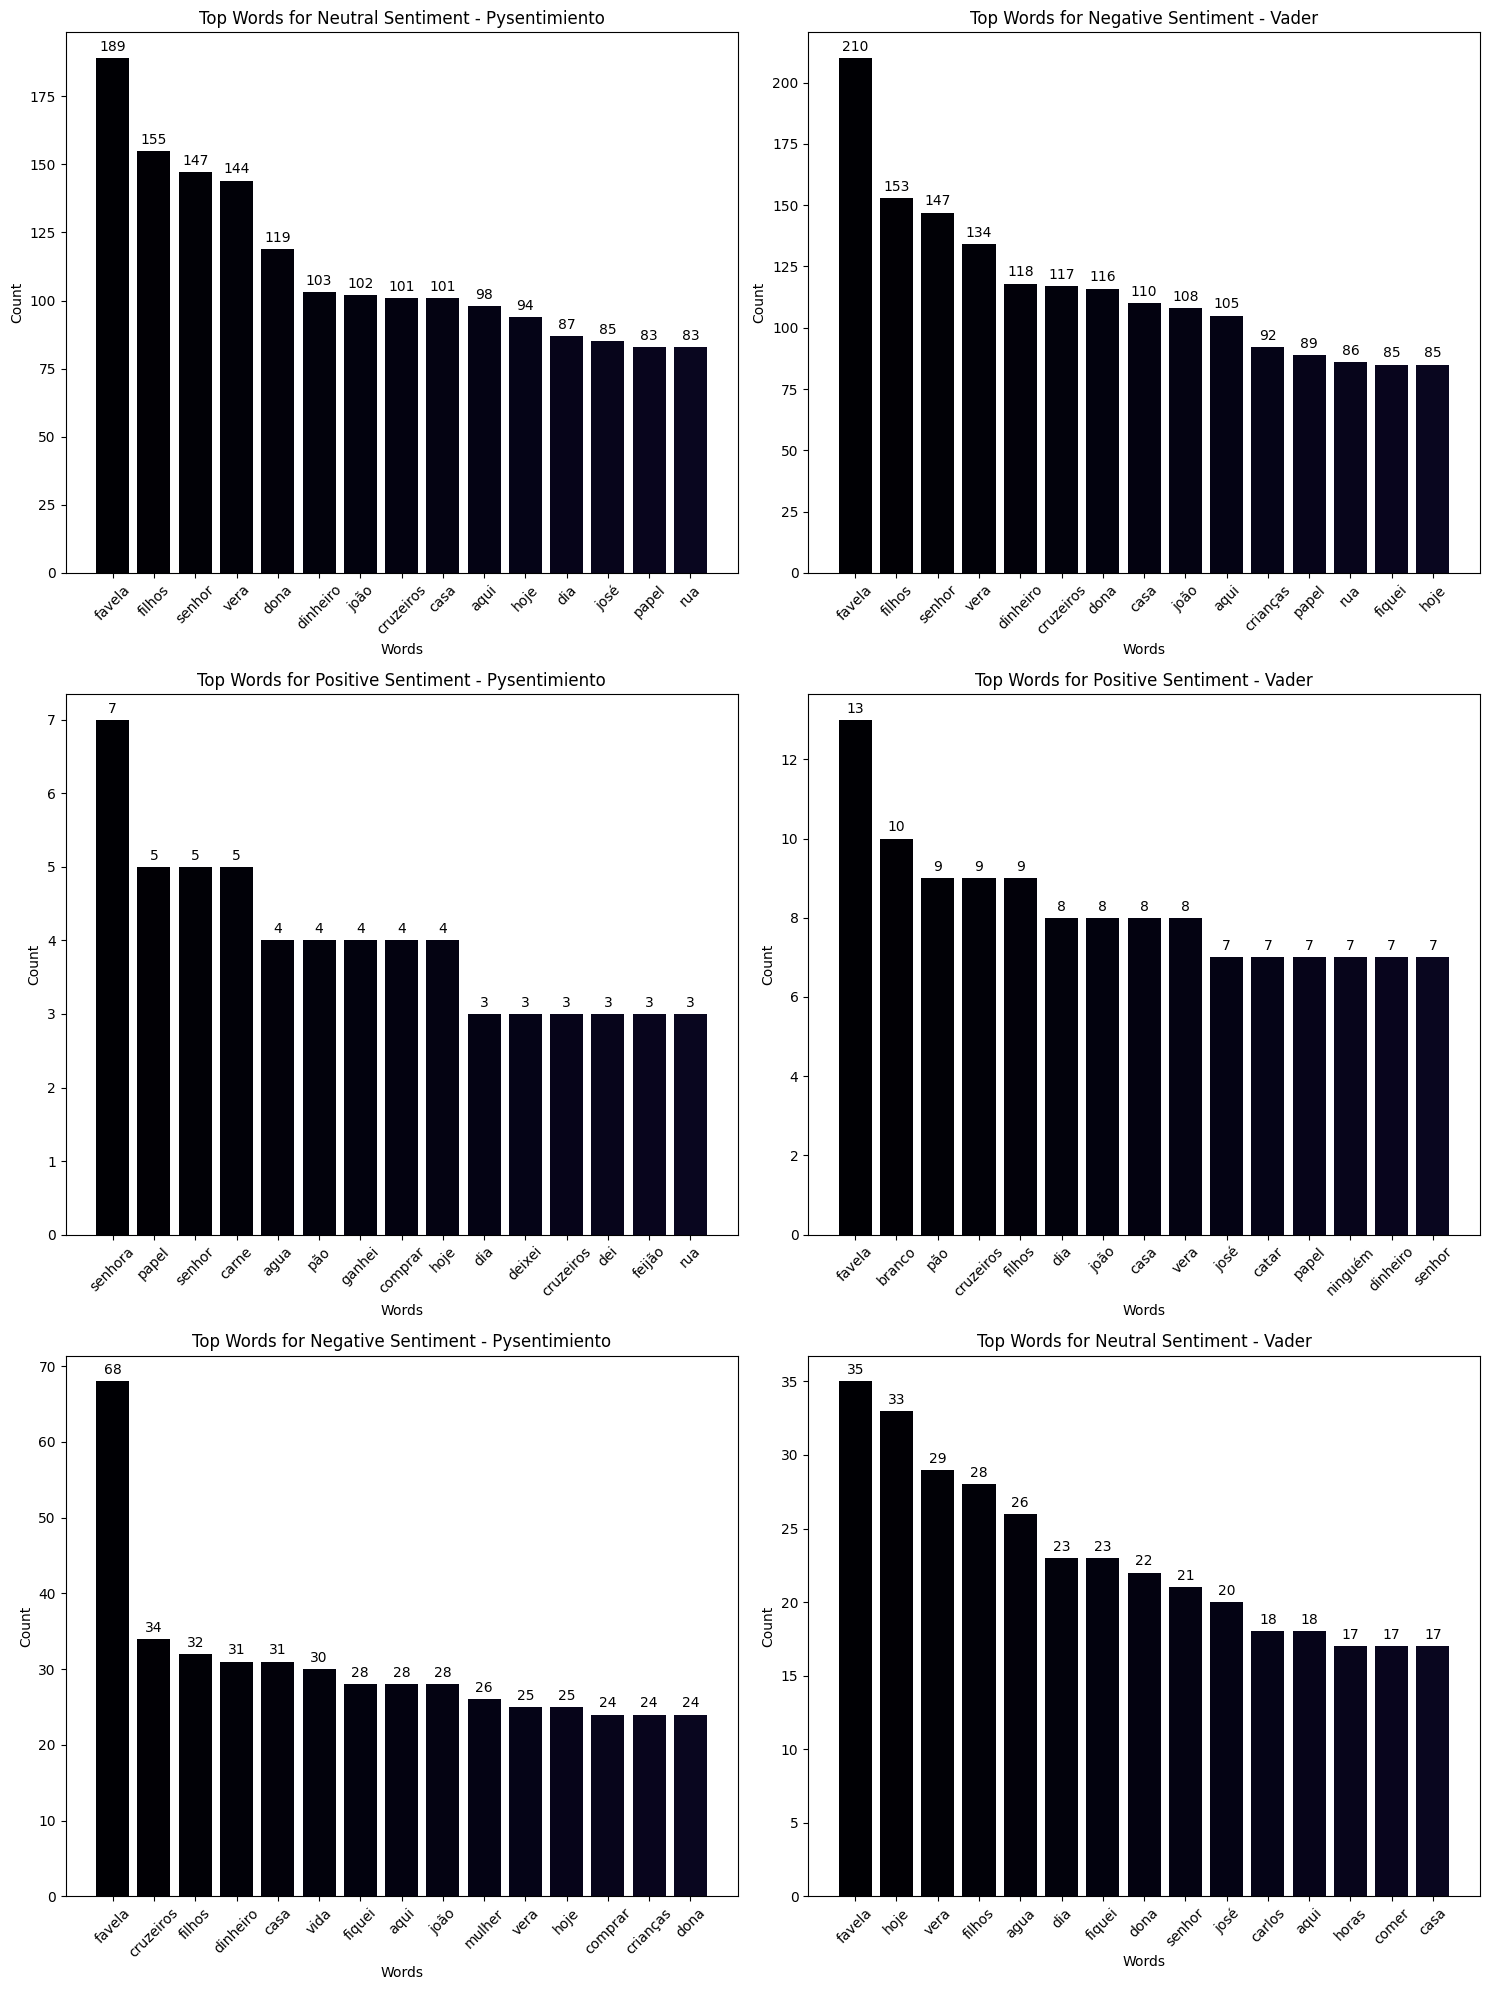

In [50]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 20))

for idx, sentiment in enumerate(df['Sentiment'].unique()):
    ax = axes[idx, 0]
    
    filtered_df = df[df['Sentiment'] == sentiment]
    combined_text = ' '.join(filtered_df['Entry'])
    
    top_words = get_top_words(combined_text, n=15, stopwords=nltk_stopwords)
    
    # Create bar plot with manually specified colormap colors
    colors = plt.get_cmap('inferno')(range(len(top_words)))
    words, counts = zip(*top_words)
    bars = ax.bar(words, counts, color=colors)
    ax.set_title(f'Top Words for {sentiment_mapping[sentiment]} Sentiment - Pysentimiento')
    ax.set_xticklabels(words, rotation=45)
    ax.set_xlabel('Words')
    ax.set_ylabel('Count')
    
    # Annotate the counts on top of the bars
    for bar, count in zip(bars, counts):
        ax.annotate(f'{count}', 
                    xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom')

for idx, sentiment in enumerate(df['Vader_Classified'].unique()):
    ax = axes[idx, 1]
    
    filtered_df = df[df['Vader_Classified'] == sentiment]
    combined_text = ' '.join(filtered_df['Entry'])
    
    top_words = get_top_words(combined_text, n=15, stopwords=nltk_stopwords)
    
    # Create bar plot with manually specified colormap colors
    colors = plt.get_cmap('inferno')(range(len(top_words)))
    words, counts = zip(*top_words)
    bars = ax.bar(words, counts, color=colors)
    ax.set_title(f'Top Words for {sentiment_mapping[sentiment]} Sentiment - Vader')
    ax.set_xticklabels(words, rotation=45)
    ax.set_xlabel('Words')
    ax.set_ylabel('Count')
    
    # Annotate the counts on top of the bars
    for bar, count in zip(bars, counts):
        ax.annotate(f'{count}', 
                    xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()